In [21]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import os.path
from sklearn.metrics import precision_score, recall_score,confusion_matrix, f1_score
from sklearn import ensemble, metrics, model_selection 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

clean_data_folder = "C:\\Users\\nateb\\OneDrive\\Desktop\\Data Science Projects\\datasets\\NFL\\Clean"
#read in data:
df = pd.DataFrame(pd.read_excel( "C:\\Users\\nateb\\OneDrive\\Desktop\\Data Science Projects\\datasets\\NFL\\Clean\\Historical Game DF averages 1999-2019.xlsx"))
for x in df.columns:
    print(x)


game_id
season
home_team
away_team
week
home_avg_first_down_yards
home_avg_second_down_yards
home_avg_4down_converted
home_avg_offensive_touchdown
home_avg_defensive_touchdown
home_avg_rush_touchdown
home_avg_pass_touchdown
home_avg_return_touchdown
home_avg_field_goal_pct
home_avg_total_yards_gained
home_avg_run_yards_gained
home_avg_pass_yards_gained
home_avg_mean_run_yards_gained
home_avg_median_air_yards
home_avg_yac
home_avg_threw_int
home_avg_fumble
home_avg_mean_epa
home_avg_median_epa
home_avg_mean_run_epa
home_avg_median_run_epa
home_avg_mean_pass_epa
home_avg_median_pass_epa
home_avg_qb_hit_nosack_allowed
home_avg_qb_scramble
home_avg_qb_hit_nosack
home_avg_qb_hit
home_avg_caused_fumble
home_avg_tackled_for_loss
home_avg_sack
home_avg_caused_turnover
home_total_avg_score
home_total_against_avg_score
home_against_avg_first_down_yards
home_against_avg_second_down_yards
home_against_avg_4down_converted
home_against_avg_offensive_touchdown
home_against_avg_defensive_touchdown
hom

First - I need to remove some variables that have too many NaN values or contain information from the game I are trying to predict

I also want to avoid having a model that will consistantly choose the favorite - so I am removing it for the time being

In the end, I'll compare these different models to the strategy of just choosing the favorite everytime

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection


df2 = df.drop(
    ['home_avg_median_air_yards',
    'home_avg_yac',
    'away_avg_median_air_yards',
    'away_avg_yac',
    'away_winner',
    'home_score',
    'away_score',
    'weather_temp',
    'weather_humidity',
    'weather_wind',
    'home_team',
    'away_team',
    'total',
    'total_line',
    'game_id',
    'home_against_avg_median_air_yards',
    'away_against_avg_median_air_yards',
    'home_avg_win_gap',
    'away_avg_win_gap',
    'home_against_avg_win_gap',
    'away_against_avg_win_gap'
    ],axis=1)


df2.head()

,season,week,home_avg_first_down_yards,home_avg_second_down_yards,home_avg_4down_converted,home_avg_offensive_touchdown,home_avg_defensive_touchdown,home_avg_rush_touchdown,home_avg_pass_touchdown,home_avg_return_touchdown,...,away_total_wins,away_total_losses,away_total_ties,indoors,div_game,home_winner,home_spread,away_spread,home_days_rest,away_days_rest
0,1999,2,2.774194,4.884615,0.000000,3.000000,0.000000,1.000000,2.000000,0.000000,...,0,1,0,0,0,0,6.5,-6.5,7,7
1,1999,5,3.528796,4.417682,0.000000,0.750000,0.250000,0.250000,0.500000,0.000000,...,3,0,0,0,1,1,9.5,-9.5,7,7
2,1999,8,4.062543,4.426144,0.285714,0.857143,0.285714,0.142857,0.714286,0.000000,...,4,3,0,0,1,0,2.5,-2.5,7,7
3,1999,10,4.179679,4.615009,0.333333,1.000000,0.222222,0.333333,0.666667,0.111111,...,5,3,0,0,1,1,6.0,-6.0,7,7
4,1999,11,4.385849,4.513508,0.300000,1.200000,0.200000,0.500000,0.600000,0.200000,...,7,2,0,0,0,0,7.0,-7.0,7,7


In [23]:
#check NA
fill_na_vars={}
for x in df2.columns:
    na = df2[x].isnull().sum()
    if na > 0:
        #print(x,na)
        fill_na_vars[x] = na
fill_na_vars

{'home_avg_field_goal_pct': 6,
 'home_against_avg_field_goal_pct': 6,
 'home_avg_td_redzone': 9,
 'home_against_avg_td_redzone': 4,
 'away_avg_field_goal_pct': 10,
 'away_against_avg_field_goal_pct': 10,
 'away_avg_td_redzone': 7,
 'away_against_avg_td_redzone': 11}

In [24]:
# Look at the observations where there is Na and evaluate how to best handle

df_na = df2.loc[df2['away_against_avg_td_redzone'].isnull()]
df_na

,season,week,home_avg_first_down_yards,home_avg_second_down_yards,home_avg_4down_converted,home_avg_offensive_touchdown,home_avg_defensive_touchdown,home_avg_rush_touchdown,home_avg_pass_touchdown,home_avg_return_touchdown,...,away_total_wins,away_total_losses,away_total_ties,indoors,div_game,home_winner,home_spread,away_spread,home_days_rest,away_days_rest
265,2000,2,5.236364,6.750000,0.0,3.0,0.0,3.0,0.0,0.0,...,1,0,0,1,0,1,-3.0,3.0,7,7
1175,2003,2,3.890909,5.150000,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,1,1,-2.5,2.5,7,7
1370,2004,2,5.158730,6.318182,1.0,2.0,0.0,1.0,1.0,0.0,...,1,0,0,0,0,1,-4.5,4.5,7,7
1452,2004,2,6.454545,6.510638,1.0,2.0,0.0,2.0,0.0,0.0,...,1,0,0,0,1,1,3.0,-3.0,7,7
2091,2007,2,5.176471,6.073171,0.0,1.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,1,-10.0,10.0,7,7
2147,2007,2,7.714286,3.666667,0.0,4.0,0.0,1.0,3.0,0.0,...,1,0,0,1,1,1,-3.0,3.0,7,7
2434,2008,2,5.053571,7.416667,1.0,4.0,0.0,3.0,1.0,0.0,...,1,0,0,0,1,1,-6.5,6.5,8,8
2490,2009,2,5.480769,3.351351,0.0,2.0,0.0,1.0,1.0,0.0,...,0,1,0,0,0,0,-7.5,7.5,7,7
2903,2010,2,5.102041,4.547619,0.0,1.0,0.0,0.0,1.0,0.0,...,1,0,0,1,0,0,-5.5,5.5,10,7
2911,2010,2,4.098039,4.162162,2.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,4.5,-4.5,8,11


These columns have null values in the first couple weeks of the data (data starts at week 2 of each season) because those events did not occur in the previous week.
For example, if the home_avg_field_goal_pct variable is null, it is because the home team did not kick a field goal yet that season

How I will fill the Na values:

    - The field goal values will be filled with the average, because the lack of field goals could mean that they were never in field goal range, or that they managed to score a touchdown everytime they were in field goal range. Additionally, there is not too much variation in kickers.
    
    - Redzone TD variables are null because that team either did not reach the redzone or did not allow the other team to reach the redzone. Those values will be replaced with 0 to most accurately portray the offense/defenses ability.
    
    


In [25]:
df2['home_avg_field_goal_pct'].fillna(df2['home_avg_field_goal_pct'].mean(),inplace=True)
df2['home_against_avg_field_goal_pct'].fillna(df2['home_against_avg_field_goal_pct'].mean(),inplace=True)
df2['away_avg_field_goal_pct'].fillna(df2['away_avg_field_goal_pct'].mean(),inplace=True)
df2['away_against_avg_field_goal_pct'].fillna(df2['away_against_avg_field_goal_pct'].mean(),inplace=True)

df2['home_avg_td_redzone'].fillna(0,inplace=True)
df2['home_against_avg_td_redzone'].fillna(0,inplace=True)
df2['away_avg_td_redzone'].fillna(0,inplace=True)
df2['away_against_avg_td_redzone'].fillna(0,inplace=True)


In [26]:
#Check Again - Good! no more null values


fill_na_vars={}
for x in df2.columns:
    na = df2[x].isnull().sum()
    if na > 0:
        #print(x,na)
        fill_na_vars[x] = na
fill_na_vars

{}

# Lets check the base case of choosing the favorite every time

In [27]:
df['base_predictions'] = df.apply(lambda x: 1 if x['home_spread'] < 0 else 0, axis = 1)
df['correct_predictions'] = df.apply(lambda x: 1 if x['home_winner'] == x['base_predictions'] else 0, axis = 1)

df['correct_predictions'].mean()

print('picking the favorite is correct {:.2f}% of the time'.format((df['correct_predictions'].mean())*100))



picking the favorite is correct 66.41% of the time


In [28]:
corr_matrix = df2.corr()

In [29]:
winner_corr_matrix = corr_matrix['home_winner'].sort_values(ascending=True)


winner_corr_limited = winner_corr_matrix.loc[abs(winner_corr_matrix) > .1]
winner_corr_limited

home_spread                               -0.360272
away_avg_mean_epa                         -0.169934
away_avg_pct_successful_play              -0.160739
away_avg_mean_pass_epa                    -0.158105
away_avg_drive_ended_with_score           -0.156892
away_total_avg_score                      -0.154445
away_avg_score                            -0.154349
away_avg_drive_ended_with_td              -0.147595
away_avg_median_epa                       -0.146846
away_avg_pass_yards_per_play              -0.143179
away_avg_offensive_touchdown              -0.142396
away_avg_median_pass_epa                  -0.140522
away_avg_pct_successful_pass              -0.136519
home_total_against_avg_score              -0.136376
home_against_avg_score                    -0.136321
away_avg_total_yards_gained               -0.134447
home_against_avg_run_yards_gained         -0.125421
home_total_losses                         -0.124161
away_avg_3down_conversion_pct             -0.121112
home_against

In [30]:
#use sklearn cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV

#separate a validation set
x_train = df2.loc[df2['season'] < 2018].drop(['home_winner'],axis=1)
x_test = df2.loc[df2['season'] == 2018].drop(['home_winner'],axis=1)
y_train = df2['home_winner'].loc[df2['season'] < 2018]
y_test = df2['home_winner'].loc[df2['season'] == 2018]
x_final_validation = df2.loc[df2['season'] == 2019].drop(['home_winner'],axis=1)
y_final_validation = df2['home_winner'].loc[df2['season'] == 2019]

standard_scaler = StandardScaler()
scaler = standard_scaler.fit(x_train)
x_train_stan = scaler.transform(x_train)
x_test_stan = scaler.transform(x_test)
x_final_valid_stan = scaler.transform(x_final_validation)


In [31]:
x_train.shape

(4740, 216)

# Random Forest Classifier



In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:


forest_clf = RandomForestClassifier(random_state=42,n_jobs=-1)

param_grid = {
    "n_estimators": [100,200,250,300,400,500],
    "max_depth":[1,2,5,7],
    "criterion":["gini","entropy"]
}

model = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=3
)
model.fit(x_train,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")
#cross_val_score(forest_clf,x_train,y_train,cv=3,scoring="accuracy")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   37.4s finished


Best score: 0.6554852320675105
Best parameters set:
	criterion:gini
	max_depth:5
	n_estimators:300


<function matplotlib.pyplot.show(close=None, block=None)>

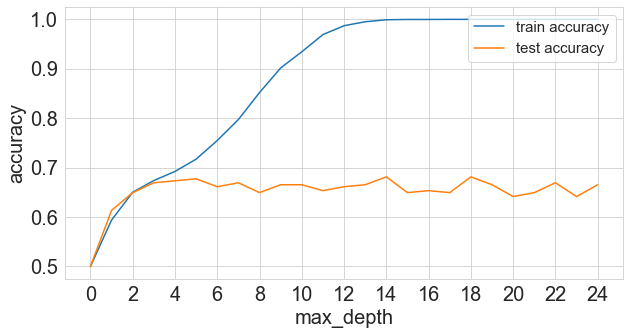

In [34]:
# Output chart to double check max depth value

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)
%matplotlib inline
train_accuracies = [0.5]
test_accuracies = [0.5]
for depth in range(1,25):

    tree_clf2 = RandomForestClassifier(criterion="gini",max_depth=depth,n_estimators=500)
    tree_clf2.fit(x_train,y_train)
    train_predictions = tree_clf2.predict(x_train)
    test_predictions = tree_clf2.predict(x_test)
    train_accuracy = metrics.accuracy_score(y_train,train_predictions)
    test_accuracy = metrics.accuracy_score(y_test,test_predictions)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
plt.plot(train_accuracies,label="train accuracy")
plt.plot(test_accuracies,label="test accuracy")
plt.legend(loc="upper right",prop={'size':15})
plt.xticks(range(0,26,2))
plt.xlabel("max_depth",size=20)
plt.ylabel("accuracy",size=20)
plt.show

# 4 looks to be good

In [69]:
final_R_forest_clf = RandomForestClassifier(random_state=42,n_jobs=-1,criterion="gini",max_depth=5,n_estimators=300)

# Logostic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:


log_reg = LogisticRegression(max_iter=10000,dual=False,solver="liblinear")
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
log_reg.fit(x_train_stan,y_train)
predictions = log_reg.predict(x_train_stan)
# accuracy_score = log_reg.score(x_test,y_test)
cross_val_score(log_reg,x_train_stan,y_train,cv=3,scoring="accuracy")


array([0.63101266, 0.61835443, 0.63987342])

In [38]:
c_lst = [x for x in range(1,20)]
c_lst.append(.001)
c_lst.append(.01)
#print(c_lst)
param_grid = {
    "penalty": ["l1","l2"],
    "C":c_lst
}

model = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=3
)
model.fit(x_train_stan,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")
    


Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.2s


Best score: 0.6656118143459916
Best parameters set:
	C:0.01
	penalty:l1


[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  1.8min finished


In [39]:
from sklearn.pipeline import make_pipeline
final_log_reg = make_pipeline(StandardScaler(),LogisticRegression(max_iter=10000,dual=False,solver="liblinear",C=.01,penalty="l1"))

# Support Vector Machine

In [40]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline

In [41]:
#try linear
svm_clf = SVC(kernel='linear')
svm_clf.fit(x_train_stan,y_train)
cross_val_score(svm_clf,x_train_stan,y_train,cv=3,scoring="accuracy")

array([0.59810127, 0.63481013, 0.64367089])

In [42]:
#try poly
for deg in range(2,10):
    svm_clf2 = SVC(kernel='poly',degree= deg)
    svm_clf2.fit(x_train_stan,y_train)
    print(cross_val_score(svm_clf2,x_train_stan,y_train,cv=3,scoring="accuracy"))


[0.47911392 0.53291139 0.52594937]
[0.61329114 0.60443038 0.57721519]
[0.54936709 0.54683544 0.55886076]
[0.58670886 0.5835443  0.57151899]
[0.56772152 0.55632911 0.56392405]
[0.5778481  0.57405063 0.56962025]
[0.56582278 0.56012658 0.56329114]
[0.57531646 0.57468354 0.57088608]


Linear looks to perform better

In [43]:
svm_clf = LinearSVC(dual=False)

In [44]:
#squared_hinge
c_lst = [x for x in range(1,10)]
c_lst.append(.001)
c_lst.append(.01)
param_grid = {
    "C":c_lst,
    "penalty": ["l1"],
    "loss" : ["squared_hinge"],
}

model = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=3
)
model.fit(x_train_stan,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")
    

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    8.2s finished


Best score: 0.660337552742616
Best parameters set:
	C:0.01
	loss:squared_hinge
	penalty:l1


In [46]:
svc_clf = SVC(kernel='linear',probability=True)

c_lst = [x for x in range(1,10)]
c_lst.append(.001)
c_lst.append(.01)
param_grid = {
    "C":c_lst
}

model = GridSearchCV(
    estimator=svc_clf,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=3
)
model.fit(x_train_stan,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed: 10.0min finished


Best score: 0.6508438818565402
Best parameters set:
	C:0.01


In [47]:

final_svm_clf= make_pipeline(StandardScaler(),SVC(kernel='linear',C=.01,probability=True))

In [70]:
final_svm_clf_linear = make_pipeline(StandardScaler(),LinearSVC(dual=False, C=.01,loss="squared_hinge",penalty="l1"))

# Decision Tree Classifier

In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:

tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train,y_train)
cross_val_score(tree_clf,x_train,y_train,cv=3,scoring="accuracy")

array([0.56898734, 0.56202532, 0.57848101])

In [50]:
#"n_estimators": [120,200,250,300,400,500],
param_grid = {
    "max_depth":[1,2,5,7,10],
    "criterion":["gini","entropy"],
    "min_samples_split":[1.0,2,5,10,15,100],
    "min_samples_leaf": [1.0,2,5,10],
    "max_features":[None,"auto","sqrt","log2"]
}

model = GridSearchCV(
    estimator=tree_clf,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    cv=5
)
model.fit(x_train,y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_params = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}:{best_params[param_name]}")
    


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2128 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3028 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 4033 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 4769 out of 4800 | elapsed:   35.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   36.7s finished


Best score: 0.660126582278481
Best parameters set:
	criterion:entropy
	max_depth:2
	max_features:None
	min_samples_leaf:2
	min_samples_split:2


<function matplotlib.pyplot.show(close=None, block=None)>

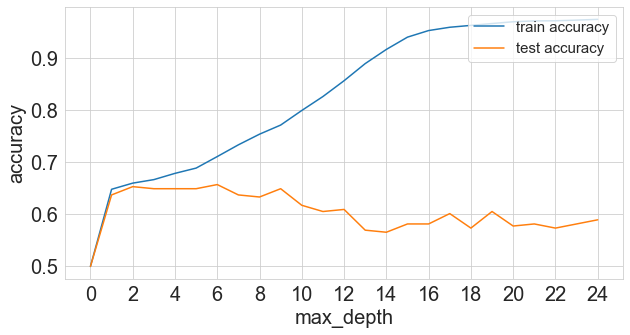

In [51]:
# Double check max depth

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)
%matplotlib inline
train_accuracies = [0.5]
test_accuracies = [0.5]
for depth in range(1,25):

    tree_clf2 = DecisionTreeClassifier(max_features=None,min_samples_leaf = 2,min_samples_split=2,criterion="gini",max_depth=depth)
    tree_clf2.fit(x_train,y_train)
    train_predictions = tree_clf2.predict(x_train)
    test_predictions = tree_clf2.predict(x_test)
    train_accuracy = metrics.accuracy_score(y_train,train_predictions)
    test_accuracy = metrics.accuracy_score(y_test,test_predictions)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
plt.plot(train_accuracies,label="train accuracy")
plt.plot(test_accuracies,label="test accuracy")
plt.legend(loc="upper right",prop={'size':15})
plt.xticks(range(0,26,2))
plt.xlabel("max_depth",size=20)
plt.ylabel("accuracy",size=20)
plt.show

# IT looks like the test accuracy peaks at a max depth of 2

# Voting Classifier to bring all of these together

So far, we have not found the right model that will beat just picking the favorite, but perhaps bringing all of this together will do the trick


In [52]:
final_tree_clf = DecisionTreeClassifier(max_features=None,min_samples_leaf = 2,min_samples_split=2,criterion="gini",max_depth=2)

In [56]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

voting_clf = VotingClassifier(
    estimators=[('Rtree',final_R_forest_clf),('svm',final_svm_clf),('tree',final_tree_clf),('logreg',final_log_reg)],
    voting='soft'
)


voting_clf.fit(x_train,y_train)
pred = voting_clf.predict(x_test)
accuracy_score(y_test,pred)
#cross_val_score(voting_clf,x_train,y_train,cv=3,scoring="accuracy")


0.6653386454183267

In [71]:
voting_clf_h = VotingClassifier(
    estimators=[('Rtree',final_R_forest_clf),('svm',final_svm_clf_linear),('tree',final_tree_clf),('logreg',final_log_reg)],
    voting='hard'
)


voting_clf_h.fit(x_train,y_train)
pred = voting_clf_h.predict(x_test)
accuracy_score(y_test,pred)

0.6613545816733067

66.5% with the soft voting classifier. Most likely, the model is picking the favorite every time. Now we need to take a look at the predictions to see if that is the case, where it is most accurate, and where it is least accurate like:
    
    - How does the model perfrom under small spreads when the teams are even?
    - How often does the model predict an upset?
    - Does the model perform better on later weeks when there is more data for that team? if so, how much?
    - How does the model perform during the playoffs?

In [66]:
# merge predictions back on to data to examine what the model predicted;

df3 = x_test.copy()
df3['predictions'] = pred

df3['Favorite'] = df3.apply(lambda x: 1 if (((x['home_spread'] < 0 ) & (x['predictions'] == 1)) | ((x['home_spread'] > 0 ) & (x['predictions'] == 0))) else 0, axis=1)
df3['upset'] = df3.apply(lambda x: 1 if x['Favorite'] == 0 else 0,axis=1)


In [68]:
df3['Favorite'].mean()

0.9840637450199203

The Model is picking the favorite 98% of the time